In [183]:

# yeni hali 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  LSTM , BatchNormalization

from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Concatenate, Attention

from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler


In [184]:
import yfinance as yf

In [185]:
import os

if os.path.exists('datas'):
    #sil
    os.system('rm -rf datas')

In [186]:
#period = '3000d'
period = 'max'


#features = ['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']
features = [ 'Close' ]  # Sadece kapanış fiyatını kullanın

#tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE','BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD','BCH-USD', 'BNB-USD', 'LINK-USD', 'ADA-USD', 'XLM-USD', 'SOL-USD', 'TRX-USD']

tickers = ['AAPL-USD']




In [187]:
def indir_ve_df_olustur(tickers, period):
    # Her bir hisse senedi için boş bir sözlük oluşturun
    pariteler = {}

    # Her bir hisse senedi için döngü oluşturun ve verileri indirin
    for ticker in tickers:
        try:
            # Hisse senedi verilerini indirin
            veri = yf.download(ticker, period=period)

            veri = veri[features]   
            # Veriyi sözlüğe ekleyin
            pariteler[ticker] = veri
            
            
        except Exception as e:
            print(f"{ticker} için veri indirilirken bir hata oluştu: {str(e)}")

    # Her bir hisse senedi için ayrı bir veri çerçevesi oluşturun
    df_listesi = [veri for veri in pariteler.values()]

    return df_listesi

In [188]:
#pariteler adında klasör oluştur :

import os 

if not os.path.exists('datas/pariteler'):
    os.makedirs('datas/pariteler')



In [189]:
datasets = indir_ve_df_olustur(tickers, period)

#pariteler içine kaydet 

for i in range(len(datasets)):
    datasets[i].to_csv(f'datas/pariteler/{tickers[i]}.csv')
    print(f'{tickers[i]} verisi csv olarak kaydedildi')


[*********************100%%**********************]  1 of 1 completed
AAPL-USD verisi csv olarak kaydedildi


In [190]:
scaler  = MinMaxScaler()

#her bir veri çerçevesi için scaled dataset oluştur

if not os.path.exists('datas/scaled_datasets'):
    os.makedirs('datas/scaled_datasets')

scaled_datasets = []

for i in range(len(datasets)):
    scaled_datasets.append(scaler.fit_transform(datasets[i]))
    np.save(f'datas/scaled_datasets/{tickers[i]}.npy', scaled_datasets[i])
    print(f'{tickers[i]} verisi scaled edilerek kaydedildi')
    

AAPL-USD verisi scaled edilerek kaydedildi


In [191]:
# her bir veri çerçevesi için veriyi dizilere bölme

seq_length = 60  # Son 60 günü kullanarak
pred_length = 7  # Önümüzdeki 7 günü tahmin etme

def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

# her bir veri çerçevesi için veriyi dizilere bölme

if not os.path.exists('datas/sequences'):
    os.makedirs('datas/sequences')

X, y = [], []

for i in range(len(scaled_datasets)):
    X_, y_ = create_sequences(scaled_datasets[i], seq_length, pred_length)
    X.append(X_)
    y.append(y_)
    np.save(f'datas/sequences/X_{tickers[i]}.npy', X_)
    np.save(f'datas/sequences/y_{tickers[i]}.npy', y_)
    print(f'{tickers[i]} verisi dizilere bölünerek kaydedildi')
    


AAPL-USD verisi dizilere bölünerek kaydedildi


In [192]:
# her bir veri çerçevesi için  seq2seq attention modeli oluştur

# Encoder
encoder_inputs = Input(shape=(seq_length, len(features)))
encoder_lstm = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = RepeatVector(pred_length)(encoder_outputs)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)


# Dikkat Mekanizması
attention_layer = Attention(use_scale=True)
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])


# TimeDistributed Dense
decoder_dense = TimeDistributed(Dense(len(features)))
decoder_outputs = decoder_dense(decoder_concat_input)

def create_model(encoder_inputs, decoder_outputs):
    model = Model(encoder_inputs, decoder_outputs)
    return model
    


In [193]:
# her bir veri çerçevesi için modeli oluştur ve eğit

if not os.path.exists('datas/models'):
    os.makedirs('datas/models')

models = []
batch_size = 64
epochs = 100

for i in range(len(scaled_datasets)):
    # modeli oluştur
    model = create_model(encoder_inputs, decoder_outputs)
    
    # modeli derle
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # modeli listeye ekle
    models.append(model)
    
    # modeli eğit
    models[i].fit(X[i], y[i],
                  batch_size=batch_size, epochs=epochs, 
                  validation_split=0.2, verbose=1)
    
    # modeli kaydet
    models[i].save(f'datas/models/{tickers[i]}_model.h5')
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')


Epoch 1/100


2024-02-04 10:37:42.155598: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


8/8 [==============================] - 6s 179ms/step - loss: 0.0663 - val_loss: 0.0433
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 0.0380

2024-02-04 10:37:43.831671: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


8/8 [==============================] - 0s 37ms/step - loss: 0.0219 - val_loss: 0.0169
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 0.0171 - val_loss: 0.0128
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0125 - val_loss: 0.0115
Epoch 5/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 6/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0087 - val_loss: 0.0118
Epoch 7/100
8/8 [==============================] - 0s 37ms/step - loss: 0.0084 - val_loss: 0.0108
Epoch 8/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0083 - val_loss: 0.0108
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 10/100
8/8 [==============================] - 0s 41ms/step - loss: 0.0079 - val_loss: 0.0101
Epoch 11/100
8/8 [==============================] - 0s 43ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 12/100
8/8 [============

/Users/mustafakapici/anaconda3/envs/all/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


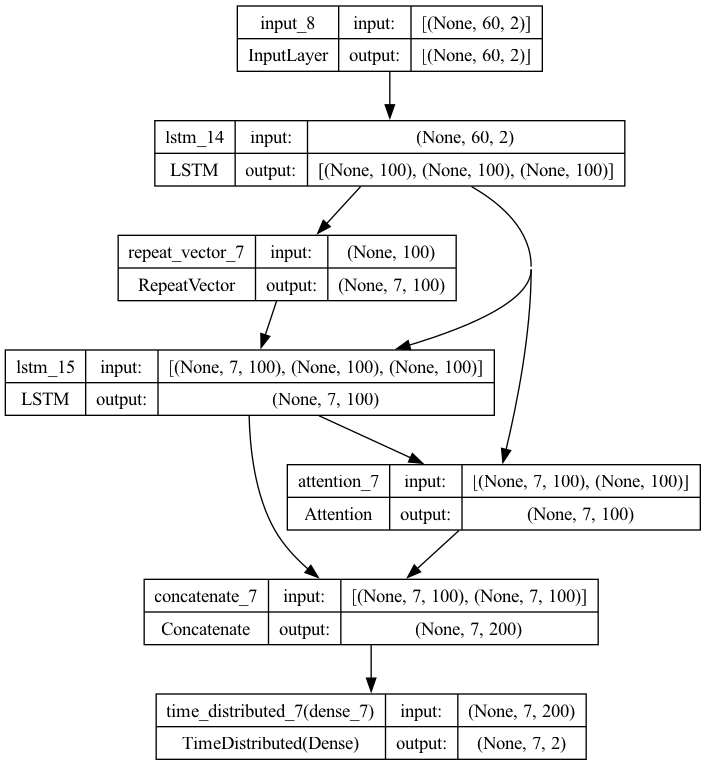

In [194]:
# modelerden bir tanesini png kaydedelim
from tensorflow.keras.utils import plot_model
plot_model(models[0], to_file='datas/model.png', show_shapes=True, show_layer_names=True , rankdir='TB', expand_nested=True, dpi=96, )

In [195]:
# her bir veri çerçevesi için last_sequence = data_scaled[-seq_length:] mantığında prediction yap

if not os.path.exists('datas/predictions'):
    os.makedirs('datas/predictions')
    
predictions = []    

for i in range(len(scaled_datasets)):
    last_sequence = scaled_datasets[i][-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    predicted = models[i].predict(last_sequence)
    
    predictions.append(predicted)
    np.save(f'datas/predictions/{tickers[i]}_prediction.npy', predicted)
    print(f'{tickers[i]} verisi için prediction yapıldı ve kaydedildi')
    

1/1 [==============================] - 1s 1s/step
AAPL-USD verisi için prediction yapıldı ve kaydedildi


2024-02-04 10:38:15.644838: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [196]:
# her bir veri çerçevesi için predictionları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/forecasts'):
    os.makedirs('datas/forecasts')
    
forecasts = []

for i in range(len(scaled_datasets)):
    predicted = predictions[i]    
    predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    forecasts.append(predicted)
    np.save(f'datas/forecasts/{tickers[i]}_forecast.npy', predicted)
    print(f'{tickers[i]} verisi için forecast yapıldı ve kaydedildi')
    
# dataframe oluştur

for i in range(len(forecasts)):
    forecast = forecasts[i]
    forecast_dates = datasets[i].index[-pred_length:]
    forecast = pd.DataFrame(forecast, index=forecast_dates, columns=[f'{tickers[i]} Forecast'])
    forecast.to_csv(f'datas/forecasts/{tickers[i]}_forecast.csv')
    print(f'{tickers[i]} verisi için forecast dataframe oluşturuldu ve kaydedildi')
    

ValueError: non-broadcastable output operand with shape (14,1) doesn't match the broadcast shape (14,2)

In [ ]:
#dataframeleri bi yazdır tarihleri ile

for i in range(len(forecasts)):
    forecast = pd.read_csv(f'datas/forecasts/{tickers[i]}_forecast.csv', index_col=0)
    print(f'{tickers[i]} verisi için forecast dataframe')
    print(forecast)

In [ ]:
# Gerçek veriyi yazdır aynı tarihteki 

for i in range(len(datasets)):
    print(f'{tickers[i]} verisi için gerçek veri')
    print(datasets[i].tail(pred_length))


## 2. Kısım

In [ ]:
# her bir veri çerçevesi için eğitime uygun full data hazırla (tensor dataset)

if not os.path.exists('datas/full_data'):
    os.makedirs('datas/full_data')
    
full_data = []

for i in range(len(scaled_datasets)):
    
    scaled_dataset_all = np.load(f'datas/scaled_datasets/{tickers[i]}.npy')
    
    scaled_dataset_all = tf.data.Dataset.from_tensor_slices(scaled_dataset_all)
    
    scaled_dataset_all = tf.data.Dataset.zip((scaled_dataset_all, scaled_dataset_all.skip(seq_length)))
    
    full_data.append(scaled_dataset_all)
    
    full_data[i] = full_data[i].batch(batch_size, drop_remainder=True).prefetch(1)
    
    full_data[i] = full_data[i].cache(f'datas/full_data/{tickers[i]}_full_data')

    print(f'{tickers[i]} verisi için full data hazırlandı')
    
    
    

In [ ]:
# her bir veri çerçevesi için modeli import et ve eğit

for i in range(len(scaled_datasets)):
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5', custom_objects={'Attention': Attention})
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(full_data[i], epochs=epochs, verbose=1)
    
    model.save(f'datas/models/{tickers[i]}_model.h5')
    
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')
    

In [ ]:
into_future = 1

def future_forecast(model, data, into_future):
    future_forecast = []
    last_sequence = data[-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    for i in range(into_future):
        predicted = model.predict(last_sequence)
        future_forecast.append(predicted)
        last_sequence = np.append(last_sequence, predicted)
        last_sequence = last_sequence[-seq_length:]
        last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    return future_forecast


In [ ]:
print( into_future , seq_length,)

In [ ]:
future_values = []

if not os.path.exists('datas/future_values'):
    os.makedirs('datas/future_values')

for i in range(len(scaled_datasets)):
    future_values.append(future_forecast(models[i], scaled_datasets[i], into_future))
    np.save(f'datas/future_values/{tickers[i]}_future_values.npy', future_values[i])
    print(f'{tickers[i]} verisi için future values yapıldı ve kaydedildi')
    

In [ ]:
# her bir veri çerçevesi için future valuesları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/future_forecasts'):
    os.makedirs('datas/future_forecasts')
    
future_forecasts = []

for i in range(len(scaled_datasets)):
    
    #np array olarak future values al
    future_value = np.load(f'datas/future_values/{tickers[i]}_future_values.npy')
    future_value = scaler.inverse_transform(future_value.reshape(-1, 1))
    future_forecasts.append(future_value)
    np.save(f'datas/future_forecasts/{tickers[i]}_future_forecast.npy', future_value)
    print(f'{tickers[i]} verisi için future forecast yapıldı ve kaydedildi')
    print(future_forecasts[i].shape)

In [ ]:
print(future_forecasts[0])

In [ ]:
print(into_future) 

In [ ]:

# dataframe oluştur

if not os.path.exists('datas/future_forecasts_df'):
    os.makedirs('datas/future_forecasts_df')

hafta = (into_future*7) + 1

for i in range(len(future_forecasts)):
    future_forecast = future_forecasts[i]
    future_forecast_dates = pd.date_range(start=datasets[i].index[-1], periods=hafta)[1:]
    future_forecast = pd.DataFrame(future_forecast, index=future_forecast_dates, columns=features)
    future_forecast.to_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv')
    print(f'{tickers[i]} verisi için future forecast dataframe oluşturuldu ve kaydedildi')